In [1]:
import os
import tensorflow as tf

# GPU 설정 및 로그 레벨 조정
os.environ.pop("CUDA_VISIBLE_DEVICES", None)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

2025-11-28 07:25:05.532063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764314705.705486      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764314705.757548      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# 라이브러리 설치
!pip -q install --no-deps "flwr==1.7.0" "iterators==0.0.2"

# Flower 라이브러리 설치 확인
try:
    import flwr as fl
    from flwr.common import parameters_to_ndarrays
    HAVE_FLWR = True
except Exception as e:
    HAVE_FLWR = False

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 7.6 MB/s eta 0:00:00


In [3]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf

# 랜덤 시드 고정
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
import google.protobuf
from google.protobuf import message_factory as _mf

if not hasattr(_mf.MessageFactory, "GetPrototype"):
    def _get_prototype(self, descriptor):
        return self.GetMessageClass(descriptor)
    _mf.MessageFactory.GetPrototype = _get_prototype

try:
    from google.protobuf import symbol_database as _sd
    _sym_db = _sd.Default()
    if not hasattr(_sym_db, "GetPrototype") and hasattr(_sym_db, "GetMessageClass"):
        _sym_db.GetPrototype = _sym_db.GetMessageClass
except Exception:
    pass

print("protobuf:", google.protobuf.__version__, "(compat patch active)")


protobuf: 6.33.0 (compat patch active)


In [5]:
# 데이터 경로 설정
BASE = Path("/kaggle/input/ciciot2023/CICIOT23")
PATH_TRAIN = BASE/"train"/"train.csv"
PATH_VAL   = BASE/"validation"/"validation.csv"
PATH_TEST  = BASE/"test"/"test.csv"

# 파일 존재 여부 검증
for p in [PATH_TRAIN, PATH_VAL, PATH_TEST]:
    assert p.exists(), f"파일을 찾을 수 없습니다: {p}"
print("Train/Val/Test CSV found")


Train/Val/Test CSV found


In [6]:
def load_csv(path):
    return pd.read_csv(path, low_memory=False)

df_train = load_csv(PATH_TRAIN)
df_val   = load_csv(PATH_VAL)
df_test  = load_csv(PATH_TEST)

# --- 이진 라벨 (Normal=0, Attack=1) ---
def to_bin(s):
    s = str(s).lower()
    return 0 if "benign" in s else 1

label_col = None
for c in ["Label","label"]:
    if c in df_train.columns:
        label_col = c; break
assert label_col, f"라벨 컬럼(Label/label) 없음: {df_train.columns[:20].tolist()}"

df_train["bin_label"] = df_train[label_col].map(to_bin)
df_val["bin_label"]   = df_val[label_col].map(to_bin)
df_test["bin_label"]  = df_test[label_col].map(to_bin)

# --- 공격 대분류(UC#1용) ---
def normalize_cat(s: str) -> str:
    s = str(s).lower()
    if "ddos" in s: return "DDoS"
    if re.search(r"\bdo?s\b", s) or "dos_" in s or "dos-" in s: return "DoS"
    if ("recon" in s) or ("scan" in s) or ("portscan" in s) or ("hostdiscovery" in s) or ("osscan" in s): return "Recon"
    if ("web" in s) or ("sql" in s) or ("xss" in s) or ("http" in s) or ("commandinjection" in s): return "Web"
    if ("brute" in s) or ("dictionary" in s): return "BruteForce"
    if "mirai" in s: return "Mirai"
    if ("spoof" in s) or ("arp" in s) or ("dns_spoof" in s): return "Spoofing"
    return "Other"

cat_col = None
for c in ["Attack","Category","AttackCategory","attack_category","category"]:
    if c in df_train.columns: cat_col = c; break

if cat_col is None:
    # 원본에 카테고리 컬럼이 없으면 라벨에서 유추
    df_train["AttackCategory"] = df_train[label_col].map(normalize_cat)
    df_val["AttackCategory"]   = df_val[label_col].map(normalize_cat)
    df_test["AttackCategory"]  = df_test[label_col].map(normalize_cat)
    cat_col = "AttackCategory"

# --- 수치 피처만 사용(상수열/결측열 제거) ---
def pick_numeric(df):
    num = df.select_dtypes(include=[np.number])
    num = num.loc[:, num.nunique() > 1]
    num = num.dropna(axis=1, how="any")
    return num

Xtr_df = pick_numeric(df_train)
Xva_df = pick_numeric(df_val)
Xte_df = pick_numeric(df_test)

# (열 교집합만 사용: train에서만 있는/없는 열 정리)
cols = sorted(set(Xtr_df.columns) & set(Xva_df.columns) & set(Xte_df.columns))

# [중요] 정답 레이블(bin_label)이 학습 피처에 포함되지 않도록 제거 (Data Leak 방지)
if "bin_label" in cols:
    print("Found 'bin_label' in features. Removing for data leak prevention.")
    cols.remove("bin_label")

Xtr_df, Xva_df, Xte_df = Xtr_df[cols], Xva_df[cols], Xte_df[cols]

y_train = df_train["bin_label"].values.astype(int)
y_val   = df_val["bin_label"].values.astype(int)
y_test  = df_test["bin_label"].values.astype(int)

cat_train = df_train[cat_col].astype(str).values

print("Shapes:", Xtr_df.shape, Xva_df.shape, Xte_df.shape)


Found 'bin_label' in features. Removing for data leak prevention.
Shapes: (5491971, 43) (1176851, 43) (1176851, 43)


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(Xtr_df.values)
X_val   = scaler.transform(Xva_df.values)
X_test  = scaler.transform(Xte_df.values)

input_dim = X_train.shape[1]
print("Input dim:", input_dim)


Input dim: 43


In [8]:
# --- Non-IID 데이터 분할 (Use Case #1: 노드별로 서로 다른 공격 유형 보유) ---
rng = np.random.RandomState(SEED)
cat_norm_train = pd.Series(cat_train).map(normalize_cat).values

# 공격 빈도수 상위 4개 유형 선정 (DDoS, DoS, Mirai, Spoofing)
atk_counts = pd.Series(cat_norm_train[y_train==1]).value_counts()
picks = list(atk_counts.index[:4])
print("Node categories:", picks)

idx_all = np.arange(len(y_train))
idx_ben = idx_all[y_train==0]; rng.shuffle(idx_ben)

MAX_BENIGN_PER_NODE = 30000
benign_per_node = min(len(idx_ben)//4, MAX_BENIGN_PER_NODE)
print("benign_per_node:", benign_per_node, "| total_benign:", len(idx_ben))

nodes = []
for i, c in enumerate(picks[:4]):
    # 1. 정상 데이터 할당
    s, e = i*benign_per_node, min((i+1)*benign_per_node, len(idx_ben))
    ben_take = idx_ben[s:e]

    # 2. 해당 노드의 공격 유형(c) 데이터 할당
    atk_idx  = idx_all[(y_train==1) & (cat_norm_train==c)]

    if len(ben_take)==0 or len(atk_idx)==0:
        print(f"[Warn] Node{i+1}({c}) skipped"); continue

    # 3. 밸런스 맞추기 (1:1 비율)
    take = min(len(ben_take), len(atk_idx))
    node_idx = np.concatenate([ben_take[:take], rng.choice(atk_idx, size=take, replace=False)])
    rng.shuffle(node_idx)
    nodes.append((X_train[node_idx], y_train[node_idx], c))
    print(f"Node{i+1}={c}: total={len(node_idx)} (benign={take}, attack={take})")

assert len(nodes) >= 4, "노드 4개 생성 실패(benign_per_node 조정 또는 picks 변경 필요)"

# (셀프 학습용) 각 노드에서 90/10 로컬 val 분할
from sklearn.model_selection import train_test_split
node_splits=[]
for Xn, yn, cname in nodes[:4]:
    Xtr, Xva, ytr, yva = train_test_split(Xn, yn, test_size=0.1, random_state=SEED, stratify=yn)
    node_splits.append(((Xtr,ytr),(Xva,yva),cname))

# 변수 개별 할당 (이후 코드 호환성 유지)
(X1_tr,y1_tr),(X1_va,y1_va),_ = node_splits[0]
(X2_tr,y2_tr),(X2_va,y2_va),_ = node_splits[1]
(X3_tr,y3_tr),(X3_va,y3_va),_ = node_splits[2]
(X4_tr,y4_tr),(X4_va,y4_va),_ = node_splits[3]


Node categories: ['DDoS', 'DoS', 'Mirai', 'Spoofing']
benign_per_node: 30000 | total_benign: 129538
Node1=DDoS: total=60000 (benign=30000, attack=30000)
Node2=DoS: total=60000 (benign=30000, attack=30000)
Node3=Mirai: total=60000 (benign=30000, attack=30000)
Node4=Spoofing: total=60000 (benign=30000, attack=30000)


In [9]:
from tensorflow import keras
from tensorflow.keras import layers

def to_cat(y):
    return keras.utils.to_categorical(y, 2)

def create_model(hidden=[128, 64], act="relu", dropout=0.5, norm=True): # 드랍아웃 0.2 -> 0.5
    inp = keras.Input(shape=(input_dim,))
    x = inp
    for u in hidden:
        x = layers.Dense(u, activation=act, kernel_initializer="he_normal")(x)
        if norm:
            x = layers.BatchNormalization()(x)
        if dropout:
            x = layers.Dropout(dropout)(x)
    out = layers.Dense(2, activation="softmax", dtype="float32")(x)
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return m


In [10]:
cb = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)]

# 중앙집중
central = create_model()
central.fit(X_train, to_cat(y_train),
            validation_data=(X_val, to_cat(y_val)),
            epochs=50, batch_size=1024, verbose=0, callbacks=cb)
_, acc_c = central.evaluate(X_test, to_cat(y_test), verbose=0)
print("[Centralized] Test ACC:", round(float(acc_c),4))

# 셀프(노드별)
acc_self = {}
for i,((Xtr,ytr),(Xva,yva),cname) in enumerate(node_splits,1):
    m = create_model()
    m.fit(Xtr, to_cat(ytr),
          validation_data=(Xva, to_cat(yva)),
          epochs=50, batch_size=1024, verbose=0, callbacks=cb)
    _, a = m.evaluate(X_test, to_cat(y_test), verbose=0)
    acc_self[f"Node{i}"] = float(a)
print("[Self] Test ACCs:", acc_self)


I0000 00:00:1764314810.116884      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1764314816.451201     124 service.cc:148] XLA service 0x7a4d5000b810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764314816.451884     124 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764314816.750550     124 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764314818.709116     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[Centralized] Test ACC: 0.9936
[Self] Test ACCs: {'Node1': 0.9813357591629028, 'Node2': 0.9521060585975647, 'Node3': 0.5503228306770325, 'Node4': 0.8572444319725037}


In [11]:
ROUNDs = 5
LOCAL_EPOCHS = 1
BATCH = 1024

# 서버/글로벌 평가 모델(라운드별 VAL만 평가)
global_eval = create_model()

def server_eval_on_val(params_or_weights):
    try:
        weights = parameters_to_ndarrays(params_or_weights) if HAVE_FLWR else params_or_weights
    except Exception:
        weights = params_or_weights
    global_eval.set_weights(weights)
    loss, acc = global_eval.evaluate(X_val, to_cat(y_val), verbose=0)
    return float(loss), float(acc)

# if HAVE_FLWR:
class SaveBestFedAvg(fl.server.strategy.FedAvg):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_params=None
        self.best_val=-1.0
        self.round_hist=[]

    def aggregate_fit(self, server_round, results, failures):
        agg, m = super().aggregate_fit(server_round, results, failures)
        if agg is not None:
            # 라운드별 Global Model 평가
            _, val = server_eval_on_val(agg)
            self.round_hist.append((server_round, val))
            # Best Model 저장
            if val > self.best_val:
                self.best_val = val; self.best_params = agg
        return agg, m

class IDSClient(fl.client.NumPyClient):
    def __init__(self, cid, X, y):
        self.X, self.y = X, y
        self.order = np.arange(len(X)); np.random.RandomState(SEED).shuffle(self.order)
        self.model = create_model()

    def get_parameters(self, config): return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        r = int(config.get("server_round", 1))
        frac = min(max(r,1), ROUNDs)/ROUNDs     # 누적 사용
        n = max(1, int(len(self.order)*frac))
        idx = self.order[:n]

        self.model.fit(self.X[idx], to_cat(self.y[idx]),
                       epochs=LOCAL_EPOCHS, batch_size=BATCH, verbose=0)
        return self.model.get_weights(), n, {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.X, to_cat(self.y), verbose=0)
        return float(loss), len(self.y), {"train_proxy_acc": float(acc)}

def client_fn(cid: str):
    i = int(cid)
    data = [(X1_tr,y1_tr),(X2_tr,y2_tr),(X3_tr,y3_tr),(X4_tr,y4_tr)]
    return IDSClient(i, *data[i])

strategy = SaveBestFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.0,
    min_fit_clients=4,
    min_evaluate_clients=0,
    min_available_clients=4,
)

history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=4,
    config=fl.server.ServerConfig(num_rounds=ROUNDs),
    strategy=strategy,
    client_resources={"num_cpus":1, "num_gpus":1.0},
    ray_init_args={"num_cpus":4, "num_gpus":1, "include_dashboard":False,
                   "runtime_env":{"env_vars":{"TF_FORCE_GPU_ALLOW_GROWTH":"true"}}},
)

# Best-VAL 파라미터로 최종 Test
best_w = parameters_to_ndarrays(strategy.best_params)
global_eval.set_weights(best_w)
_, acc_fl = global_eval.evaluate(X_test, to_cat(y_test), verbose=0)
round_hist = strategy.round_hist
print(f"[Federated(Flower)@Best-VAL] Test ACC: {acc_fl:.4f}")



INFO flwr 2025-11-28 07:36:38,124 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2025-11-28 07:36:42,877	INFO worker.py:2012 -- Started a local Ray instance.
/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
INFO flwr 2025-11-28 07:36:47,321 | app.py:213 | Flower VCE: Ray initialized with resources: {'object_store_memory': 6080399769.0, 'CPU': 4.0, 'accelerator_type:P100': 1.0, 'GPU': 1.0, 'node:172.19.2.2': 1.0, 'memory': 14187599463.0, 'node:__internal_head__': 1.0}
INFO flwr 2025-11-28 07:36:47,322 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2025-11-28 07:36:47,323 | 

[Federated(Flower)@Best-VAL] Test ACC: 0.9280


In [12]:
# pFL 미세조정(fine-tuning)
PFL_EPOCHS = 10 # 미세조정 에포크
acc_pfl = {} # 개인화 모델의 성능을 저장할 딕셔너리

print("--- pFL (개인화 연합 학습) 미세조정 시작 ---")

# node_splits = [((X1tr,y1tr),(X1va,y1va),c1), ((X2tr,y2tr),(X2va,y2va),c2), ...]
for i, ((Xtr, ytr), (Xva, yva), cname) in enumerate(node_splits, 1):

    # 1. 새 개인화 모델 생성
    p_model = create_model()

    # 2. FL로 학습된 글로벌 모델 가중치 로드
    p_model.set_weights(best_w)

    print(f"\n[Node {i} ({cname})] 개인화 미세조정 시작...")

    # 3. 로컬 데이터로만 모델을 추가 학습
    p_model.fit(Xtr, to_cat(ytr),
                validation_data=(Xva, to_cat(yva)),
                epochs=PFL_EPOCHS,
                batch_size=BATCH,
                callbacks=cb, # EarlyStopping(monitor='val_accuracy', patience=3) 사용
                verbose=0)

    # 4. PFL 모델 성능 평가
    _, a = p_model.evaluate(X_test, to_cat(y_test), verbose=0)
    acc_pfl[f"Node{i}"] = float(a)

    print(f"[Node {i} ({cname})] 개인화 완료. Test ACC: {a:.4f}")

print("\n--- 모든 pFL 성능 측정 완료 ---")

--- pFL (개인화 연합 학습) 미세조정 시작 ---

[Node 1 (DDoS)] 개인화 미세조정 시작...
[Node 1 (DDoS)] 개인화 완료. Test ACC: 0.9819

[Node 2 (DoS)] 개인화 미세조정 시작...
[Node 2 (DoS)] 개인화 완료. Test ACC: 0.9650

[Node 3 (Mirai)] 개인화 미세조정 시작...
[Node 3 (Mirai)] 개인화 완료. Test ACC: 0.9590

[Node 4 (Spoofing)] 개인화 미세조정 시작...
[Node 4 (Spoofing)] 개인화 완료. Test ACC: 0.9781

--- 모든 pFL 성능 측정 완료 ---


---

In [13]:
print("\n" + "="*95)
print(f"{'FINAL PERFORMANCE COMPARISON':^95}")
print("="*95)
print(f"| {'Model Strategy':<22} | {'Node 1 (DDoS)':<15} | {'Node 2 (DoS)':<15} | {'Node 3 (Mirai)':<15} | {'Node 4 (Spoofing)':<15} |")
print(f"|{'-'*24}|{'-'*17}|{'-'*17}|{'-'*17}|{'-'*17}|")

# 1. Self-Learning Results
n1_s, n2_s, n3_s, n4_s = [acc_self.get(f'Node{i}', 0) for i in range(1, 5)]
print(f"| {'Self-Learning':<22} | {n1_s:<15.4f} | {n2_s:<15.4f} | {n3_s:<15.4f} | {n4_s:<15.4f} |")

# 2. Federated Learning (Global) Results
print(f"| {'FedAvg (Global)':<22} | {acc_fl:<15.4f} | {acc_fl:<15.4f} | {acc_fl:<15.4f} | {acc_fl:<15.4f} |")

# 3. Personalized FL Results
n1_p, n2_p, n3_p, n4_p = [acc_pfl.get(f'Node{i}', 0) for i in range(1, 5)]
print(f"| {'Personalized FL':<22} | {n1_p:<15.4f} | {n2_p:<15.4f} | {n3_p:<15.4f} | {n4_p:<15.4f} |")
print("="*95)


                                 FINAL PERFORMANCE COMPARISON                                  
| Model Strategy         | Node 1 (DDoS)   | Node 2 (DoS)    | Node 3 (Mirai)  | Node 4 (Spoofing) |
|------------------------|-----------------|-----------------|-----------------|-----------------|
| Self-Learning          | 0.9813          | 0.9521          | 0.5503          | 0.8572          |
| FedAvg (Global)        | 0.9280          | 0.9280          | 0.9280          | 0.9280          |
| Personalized FL        | 0.9819          | 0.9650          | 0.9590          | 0.9781          |



[ Centralized Model ] Test Accuracy: 0.9936
------------------------------------------------------------
Confusion Matrix:
 [[  24672    3037]
 [   4510 1144632]]

Classification Report:
               precision    recall  f1-score   support

      Normal       0.85      0.89      0.87     27709
      Attack       1.00      1.00      1.00   1149142

    accuracy                           0.99   1176851
   macro avg       0.92      0.94      0.93   1176851
weighted avg       0.99      0.99      0.99   1176851


[ Federated Global Model ] Test Accuracy: 0.9280
------------------------------------------------------------
Confusion Matrix:
 [[  27706       3]
 [  84717 1064425]]

Classification Report:
               precision    recall  f1-score   support

      Normal       0.25      1.00      0.40     27709
      Attack       1.00      0.93      0.96   1149142

    accuracy                           0.93   1176851
   macro avg       0.62      0.96      0.68   1176851
weighted avg      

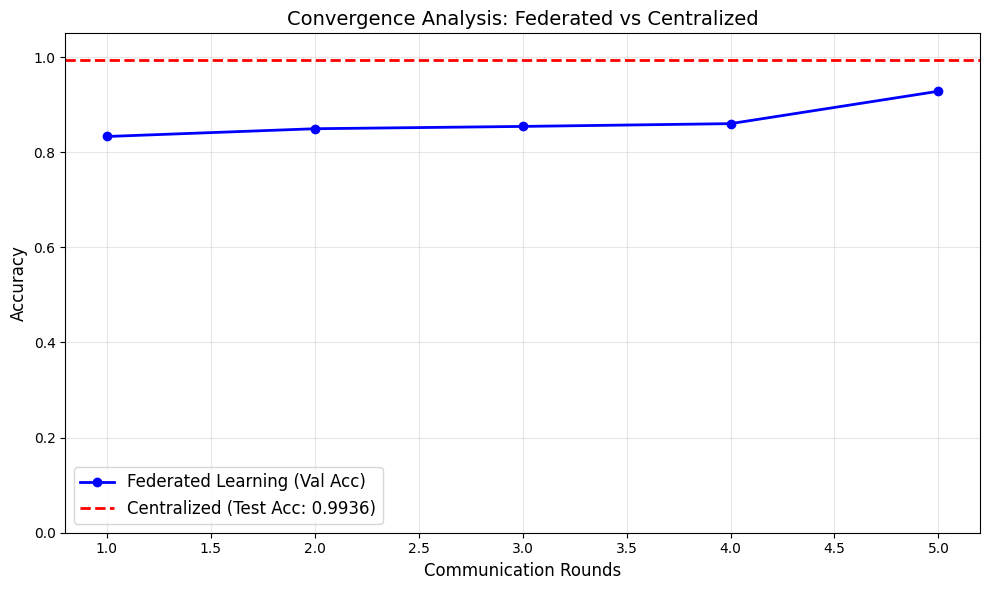

In [14]:
# --- 상세 성능 리포트 (Confusion Matrix & F1-Score) ---

def print_report(model, title):
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n[ {title} ] Test Accuracy: {acc:.4f}")
    print("-" * 60)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Normal", "Attack"]))

# 1. Centralized Model Report
print_report(central, "Centralized Model")

# 2. Federated Global Model Report
print_report(global_eval, "Federated Global Model")


# --- 학습 곡선 시각화 (FL vs Centralized) ---
rs = [r for (r, _) in round_hist]
accs = [a for (_, a) in round_hist]

plt.figure(figsize=(10, 6))
plt.plot(rs, accs, marker="o", linestyle='-', linewidth=2, color='blue', label="Federated Learning (Val Acc)")
plt.axhline(y=acc_c, color='red', linestyle='--', linewidth=2, label=f"Centralized (Test Acc: {acc_c:.4f})")

plt.title("Convergence Analysis: Federated vs Centralized", fontsize=14)
plt.xlabel("Communication Rounds", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()